In [1]:
import pandas as pd
import numpy as np
import json
import os
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

# Load in 2022-2023 Regular Season Data
# Link: https://www.basketball-reference.com/leagues/NBA_2022_advanced.html

# Read the CSV file into a DataFrame

reg21_22 = pd.read_csv("2021-2022reg.csv")

# Clean Data

reg21_22.drop(index = 0, inplace = True)
columns_to_drop = ["Unnamed: 19", "Unnamed: 24", "Player-additional", "Rk"]
reg21_22.drop(columns=columns_to_drop, axis=1, inplace=True)

reg21_22 = reg21_22[reg21_22["Tm"] != "TOT"]

# Load in 2022-2023 Playoff Data
# Link: https://www.basketball-reference.com/playoffs/NBA_2022_advanced.html

# Read the CSV file into a DataFrame

playoff21_22 = pd.read_csv("2021-2022playoff.csv")

# Clean Data

columns_to_drop = ["Unnamed: 19", "Unnamed: 24", "Player-additional", "Rk"]
playoff21_22.drop(columns=columns_to_drop, axis=1, inplace=True)

In [3]:
raptor_df = pd.read_csv("modern_RAPTOR_by_team.csv")

In [4]:
#Clean Data

# Specify the columns you want to keep
columns_to_keep = ["player_name","season","season_type","team","poss","mp","raptor_offense","raptor_total",
                   "war_total","war_reg_season","war_playoffs","predator_offense","predator_total"]

# Keep only the specified columns
raptor_df = raptor_df[columns_to_keep]

raptor_df.head()

,player_name,season,season_type,team,poss,mp,raptor_offense,raptor_total,war_total,war_reg_season,war_playoffs,predator_offense,predator_total
0,Alex Abrines,2017,PO,OKC,172,80,-0.892617,-7.453875,-0.198700,0.000000,-0.198700,-3.298178,-9.833292
1,Alex Abrines,2017,RS,OKC,2215,1055,0.654933,-0.069300,1.447708,1.447708,0.000000,0.339201,-0.272665
2,Alex Abrines,2018,PO,OKC,233,110,1.875157,2.615450,0.311392,0.000000,0.311392,2.877519,2.356566
3,Alex Abrines,2018,RS,OKC,2313,1134,-0.211818,-1.940401,0.465912,0.465912,0.000000,-0.482078,-1.654306
4,Alex Abrines,2019,RS,OKC,1279,588,-4.040157,-2.154538,0.178167,0.178167,0.000000,-4.577678,-3.034396


In [5]:
#Get Just 2021-2022 Season

raptor_df_2022 = raptor_df[raptor_df["season"] == 2022]

raptor_df_2022

,player_name,season,season_type,team,poss,mp,raptor_offense,raptor_total,war_total,war_reg_season,war_playoffs,predator_offense,predator_total
7,Precious Achiuwa,2022,PO,TOR,320,167,-2.531130,-3.286191,-0.046953,0.000000,-0.046953,-3.958067,-4.409724
8,Precious Achiuwa,2022,RS,TOR,3482,1725,-2.516108,-0.105515,2.309611,2.309611,0.000000,-2.348484,-0.096575
37,Steven Adams,2022,PO,MEM,245,114,1.708276,-0.699908,0.123000,0.000000,0.123000,0.620153,-2.306824
38,Steven Adams,2022,RS,MEM,4147,1999,1.684133,2.303361,5.140587,5.140587,0.000000,1.417837,3.207289
46,Bam Adebayo,2022,PO,MIA,1197,614,0.812913,4.085476,2.172589,0.000000,2.172589,0.093798,3.393456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7244,Trae Young,2022,RS,ATL,5536,2652,7.615987,4.417909,9.903858,9.903858,0.000000,7.257725,3.863434
7245,Omer Yurtseven,2022,PO,MIA,80,38,-0.384915,-0.926403,0.036325,0.000000,0.036325,-1.215995,-3.846854
7246,Omer Yurtseven,2022,RS,MIA,1445,706,-2.141570,-1.186370,0.563127,0.563127,0.000000,-2.314126,-1.982086
7257,Cody Zeller,2022,RS,POR,748,355,-0.222446,-3.449202,-0.127035,-0.127035,0.000000,-0.396488,-2.797523


In [34]:
reg21_22['MP'].mean()
playoff21_22

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,vorp_post
0,Precious Achiuwa,C,22,TOR,6,167,10.9,0.541,0.308,0.192,...,13.8,18.2,0.0,0.0,0.0,-0.014,-2.4,-1.0,-3.3,-0.1
1,Steven Adams,C,28,MEM,7,114,12.8,0.464,0.000,0.524,...,13.4,10.7,0.2,0.2,0.3,0.128,-1.6,0.5,-1.1,0.0
2,Bam Adebayo,C,24,MIA,18,614,17.9,0.638,0.006,0.434,...,15.4,17.9,1.2,1.0,2.2,0.169,0.9,2.0,2.9,0.8
3,Nickeil Alexander-Walker,SG,23,UTA,1,5,66.5,1.025,0.000,0.500,...,0.0,22.9,0.1,0.0,0.1,0.810,27.8,22.3,50.1,0.1
4,Grayson Allen,SG,26,MIL,12,305,10.3,0.576,0.585,0.134,...,9.4,13.6,0.2,0.5,0.7,0.115,-1.0,1.2,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,Ziaire Williams,SF,20,MEM,10,168,11.8,0.598,0.692,0.250,...,3.3,14.6,0.3,0.1,0.4,0.126,-0.9,0.4,-0.6,0.1
213,Delon Wright,SG,29,ATL,5,137,15.9,0.622,0.448,0.310,...,13.2,12.8,0.3,0.1,0.4,0.130,3.3,1.5,4.8,0.2
214,Thaddeus Young,PF,33,TOR,6,87,14.3,0.506,0.389,0.222,...,13.2,12.1,0.1,0.0,0.1,0.067,-0.6,2.3,1.7,0.1
215,Trae Young,PG,23,ATL,5,186,5.3,0.461,0.551,0.478,...,27.1,28.3,-0.6,0.1,-0.5,-0.139,-4.0,-4.1,-8.1,-0.3


In [35]:
# Renaming 'vorp' in data frames so they can join
reg21_22 = reg21_22.rename(columns={'VORP': 'vorp_reg'})

playoff21_22 = playoff21_22.rename(columns={'VORP': 'vorp_post'})

# changing name of player column in raptor to join
raptor_df_2022 = raptor_df_2022.rename(columns={'player_name': 'Player', 'Tm': 'team'})

# filter reg season players by 1000 minutes played
reg21_22 = reg21_22[reg21_22['MP'] > 1000]

# Performing the joins
result = pd.merge(raptor_df_2022, reg21_22, on='Player', how='inner')
result = pd.merge(result, playoff21_22, on='Player', how='inner')

In [41]:
# keeping the varaibles we want and dropping everything else

columns_to_keep = ['Player', 'season', 'season_type', 'team', 'mp', 'raptor_total', 'war_total', 'predator_total', 'vorp_reg', 'vorp_post', 'G_y']
result = result[columns_to_keep]

result['post_mpg'] = result['mp']/result['G_y']

result.loc[result['season_type'] == 'RS', 'post_mpg'] = pd.NA

In [44]:
# Filter post-season players with more than 20 post_mpg
filtered_post_season_players = result[(result['season_type'] == 'PO') & (result['post_mpg'] >= 20)]

# Concatenate the regular-season players with the filtered post-season players
final_result = pd.concat([result[result['season_type'] == 'RS'], filtered_post_season_players])

final_result.to_csv("master.csv", index = False)

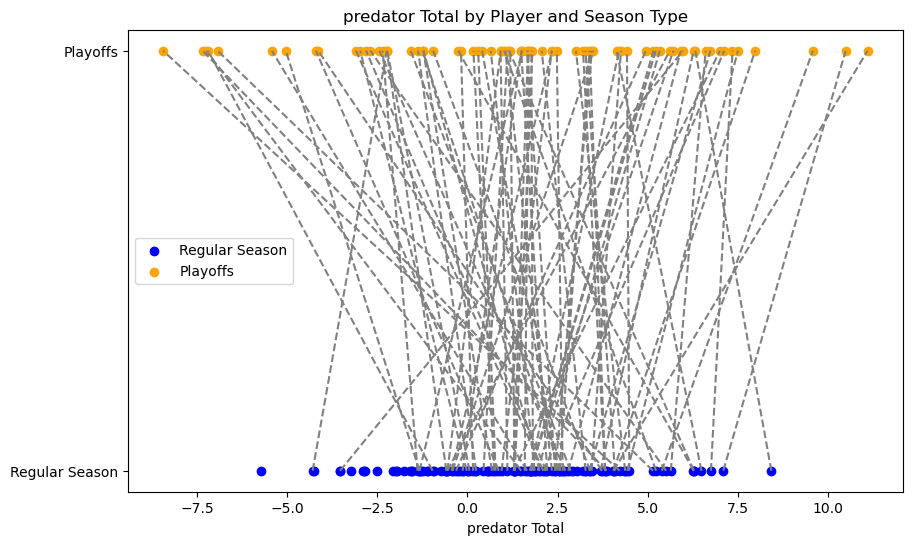

In [49]:
# make graph comparing reg and post season

# Predator

# Create a new DataFrame for plotting
df_pivot = final_result.pivot(index='Player', columns='season_type', values='predator_total')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_pivot['RS'], [0] * len(df_pivot['RS']), label='Regular Season', color='blue', marker='o')
plt.scatter(df_pivot['PO'], [1] * len(df_pivot['PO']), label='Playoffs', color='orange', marker='o')

for player in df_pivot.index:
    rs_value = df_pivot.loc[player, 'RS']
    po_value = df_pivot.loc[player, 'PO']
    plt.plot([rs_value, po_value], [0, 1], color='gray', linestyle='--')

# Customize the plot
plt.yticks([0, 1], ['Regular Season', 'Playoffs'])
plt.xlabel('predator Total')
plt.title('predator Total by Player and Season Type')
plt.legend()

# Show the plot
plt.show()

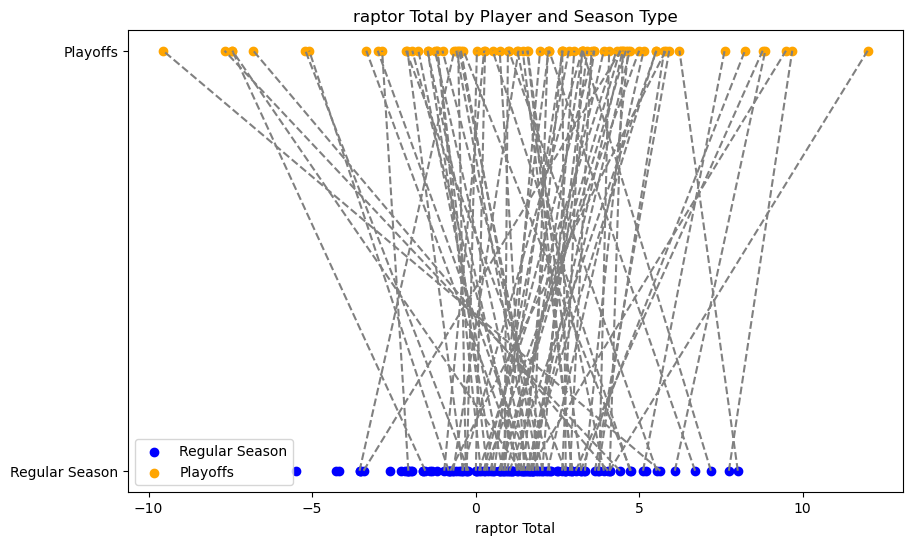

In [50]:
# Raptor

# Create a new DataFrame for plotting
df_pivot = final_result.pivot(index='Player', columns='season_type', values='raptor_total')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_pivot['RS'], [0] * len(df_pivot['RS']), label='Regular Season', color='blue', marker='o')
plt.scatter(df_pivot['PO'], [1] * len(df_pivot['PO']), label='Playoffs', color='orange', marker='o')

for player in df_pivot.index:
    rs_value = df_pivot.loc[player, 'RS']
    po_value = df_pivot.loc[player, 'PO']
    plt.plot([rs_value, po_value], [0, 1], color='gray', linestyle='--')

# Customize the plot
plt.yticks([0, 1], ['Regular Season', 'Playoffs'])
plt.xlabel('raptor Total')
plt.title('raptor Total by Player and Season Type')
plt.legend()

# Show the plot
plt.show()

ValueError: x and y must be the same size

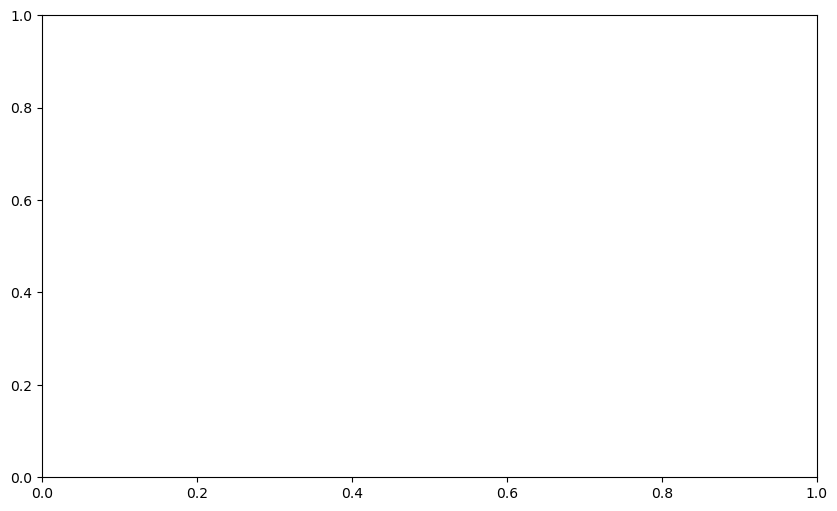

In [52]:
# Create a new DataFrame for plotting with 'vorp_reg' and 'vorp_post' columns
df_pivot = final_result.pivot(index='Player', columns='season_type')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_pivot['vorp_reg'], [0] * len(df_pivot['vorp_reg']), label='Regular Season', color='blue', marker='o')
plt.scatter(df_pivot['vorp_post'], [1] * len(df_pivot['vorp_post']), label='Playoffs', color='orange', marker='o')

for player in df_pivot.index:
    rs_value = df_pivot.loc[player, ('vorp_reg', 'RS')]
    po_value = df_pivot.loc[player, ('vorp_post', 'PO')]
    plt.plot([rs_value, po_value], [0, 1], color='gray', linestyle='--')

# Customize the plot
plt.yticks([0, 1], ['Regular Season', 'Playoffs'])
plt.xlabel('vorp')
plt.title('vorp by Player and Season Type')
plt.legend()

# Show the plot
plt.show()

In [47]:
# final_result['raptor_total'].min()
final_result[final_result['raptor_total']==-9.556694834471037]

,Player,season,season_type,team,mp,raptor_total,war_total,predator_total,vorp_reg,vorp_post,G_y,post_mpg
70,Kevin Durant,2022,PO,BRK,176,-9.556695,-0.665206,-6.927454,4.8,0.0,4,44.0
